In [ ]:
# Импортируем необходимые библиотека
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [ ]:
# Несколько вспомогательных методов

def getDistanceByPoint(data, model):
    # Расчет расстояний от точек до центров кластеров
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

def getTransitionMatrix (df):
    # Расчет вероятностей перехода к следующему состоянию (глупая предсказывалка)
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1)
	return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    # Поиск аномалий в последовательности сигналов исходя из марковской матрицы переходов
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

In [ ]:
df = pd.read_csv("/content/ambient_temperature_system_failure.csv")

In [ ]:
#Посмотрим на данные
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


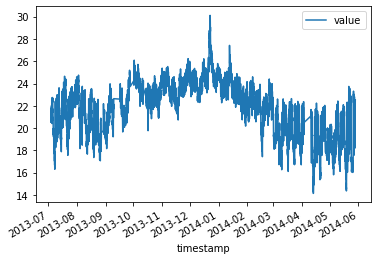

In [ ]:
#пересчитаем температуру в цельсии, как привычнее
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] - 32) * 5 /9
df.plot(x='timestamp', y='value')

In [ ]:
#Начнем генерацию фичей
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
outliers_fraction = 0.01

In [ ]:
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  """Entry point for launching an IPython kernel.


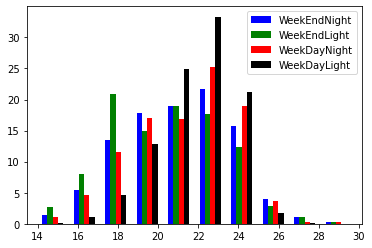

In [ ]:
#Хак чтобы получить признак день недели + день-ночь (0 - утро понедельника)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

# Clustering models

In [ ]:
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]

# Нормализуем наши данные
starrd_scaler = preprocessing.StandardScaler().fit(data)
np_scaled = starrd_scaler.transform(data)
data = pd.DataFrame(np_scaled)

# Уменьшим количество компонент
pca = PCA(n_components=2)
data = pca.fit_transform(data)

min_max_scaler = preprocessing.StandardScaler().fit(data)
np_scaled = min_max_scaler.transform(data)
data = pd.DataFrame(np_scaled)

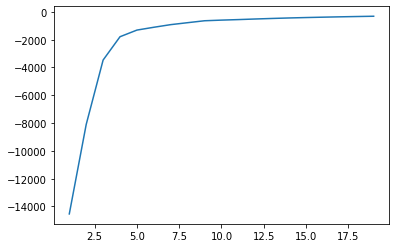

In [ ]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=j).fit(data) for j in n_cluster]
scores = [km.score(data) for km in kmeans]
#TODO давайте подберем оптимальное число кластеров k-means
#TODO обучить KMeans для заданных числе кластеров
#TODO как подобрать число кластеров?
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [ ]:
df['cluster'] = kmeans[3].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

1    3721
2    1522
0    1428
3     596
Name: cluster, dtype: int64

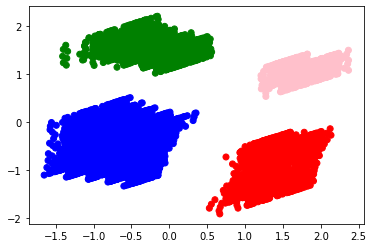

In [ ]:
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [ ]:
distance = getDistanceByPoint(data, kmeans[3])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

# Считаем точку аномалией, если расстояние до центра кластера больше порога
df['anomaly21'] = (distance >= 3.0).astype(int)

fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


AttributeError: ignored

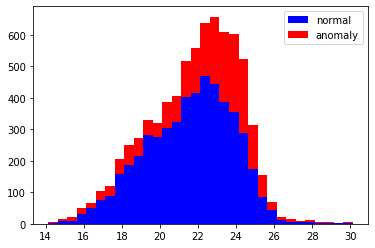

In [ ]:
# Посмотрим на распределение аномальных и действительных значений
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']
fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

In [ ]:
# creation of 4 differents data set based on categories defined before
df_class0 = df.loc[df['categories'] == 0, 'value']
df_class1 = df.loc[df['categories'] == 1, 'value']
df_class2 = df.loc[df['categories'] == 2, 'value']
df_class3 = df.loc[df['categories'] == 3, 'value']


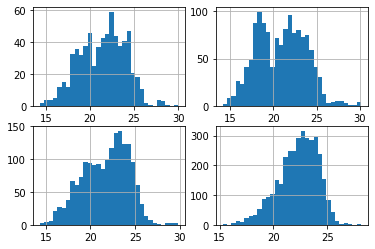

In [ ]:
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

In [ ]:
# Попробуем статистически оценить количество аномалий

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

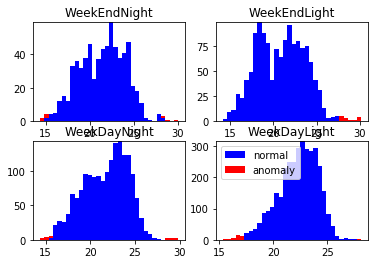

In [ ]:
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [ ]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int) 

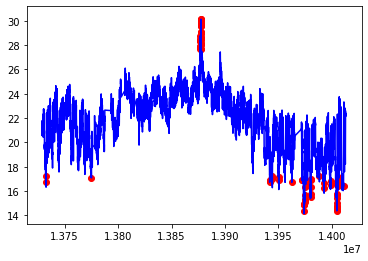

In [ ]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()


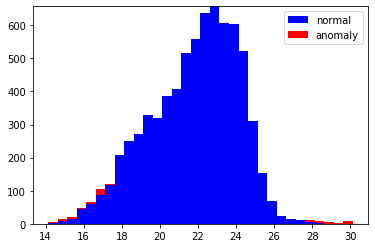

In [ ]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

In [ ]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
# train isolation forest 
model =  IsolationForest(contamination=0.5, random_state=42).fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

/home/kinetik/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


0    3634
1    3633
Name: anomaly25, dtype: int64


/home/kinetik/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [ ]:
df['value_diff'] = df['value'].diff(1)
df.dropna(inplace=True)

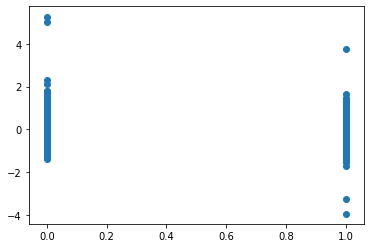

In [ ]:
plt.scatter(df['anomaly25'], df['value_diff'])

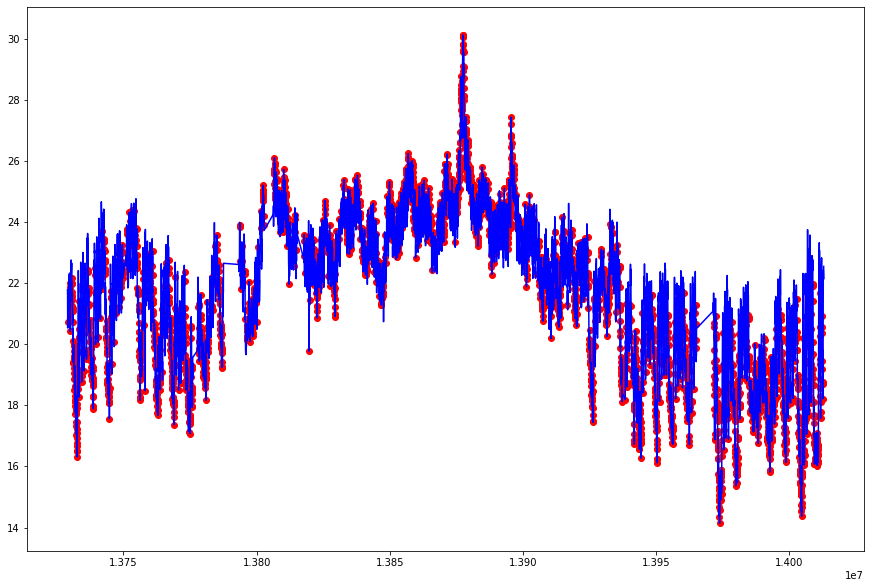

In [ ]:
# visualisation of anomaly throughout time (viz 1)
plt.figure(figsize=(15, 10))

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

plt.plot(df['time_epoch'], df['value'], color='blue')
plt.scatter(a['time_epoch'],a['value'], color='red')
plt.show()


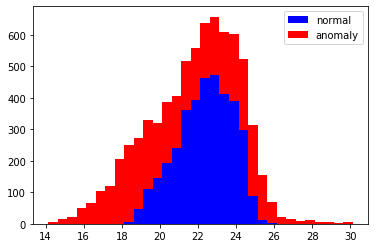

In [ ]:
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

In [ ]:
# Применим OneClassSvm

from sklearn.preprocessing import MinMaxScaler

data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data)
 
model = OneClassSVM()
data = pd.DataFrame(np_scaled)
model.fit(data)  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())


/home/kinetik/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


1.0    3633
0.0    3632
Name: anomaly26, dtype: int64


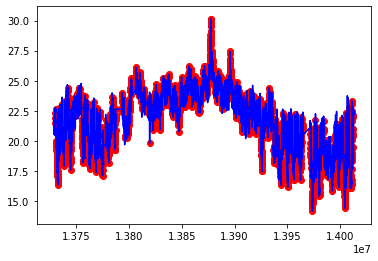

In [ ]:
#visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

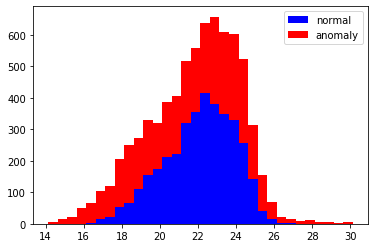

In [ ]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly26'] == 0, 'value']
b = df.loc[df['anomaly26'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()